In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import seaborn as sns
from random import shuffle, randint
from tqdm import tqdm
from sklearn.neighbors import BallTree,KDTree
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import haversine_distances, euclidean_distances
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from math import radians
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split 
pd.set_option('display.max_columns', None)
from scipy.spatial import distance_matrix
from verstack.stratified_continuous_split import scsplit
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.inspection import permutation_importance
from pyproj import Proj, transform


from keras import Model
from tensorflow import keras
from keras.layers import Dense, Input
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from random import randint
from sklearn.ensemble import VotingRegressor
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization
from math import radians,degrees

import folium
from folium.plugins import HeatMap
import branca
import branca.colormap as cm

import pickle


Using TensorFlow backend.


In [2]:
DEPARTMENT = 91

In [3]:
df = pd.read_csv('../Datas/Processed_data/{}.csv'.format(DEPARTMENT))

In [4]:
df.head()

id_mutation nature_mutation  valeur_fonciere  code_postal  code_commune  \
0  2014-951679           Vente         124500.0      91800.0         91097   
1  2014-951787           Vente         156000.0      91800.0         91097   
2  2014-951858           Vente         173000.0      91800.0         91097   
3  2014-951860           Vente         110000.0      91800.0         91097   
4  2014-951866           Vente         294000.0      91800.0         91097   

   code_departement  type_local  surface_reelle_bati  \
0                91         0.0                 75.0   
1                91         0.0                 94.0   
2                91         0.0                 55.0   
3                91         0.0                 65.0   
4                91         1.0                 90.0   

   nombre_pieces_principales  surface_terrain  longitude  latitude  \
0                          4              0.0   0.044224  0.849716   
1                          5              0.0   0.044167  0.849698   
2                          3              0.0   0.044100  0.849634   
3                          3              0.0   0.044167  0.849698   
4                          5            356.0   0.044095  0.849634   

  type_local_str  year  quarter  month  Prix_m2_bati  Prix_m2_total  \
0    Appartement  2014        1      1   1660.000000    1660.000000   
1    Appartement  2014        1      1   1659.574468    1659.574468   
2    Appartement  2014        1      2   3145.454545    3145.454545   
3    Appartement  2014        1      1   1692.307692    1692.307692   
4         Maison  2014        1      1   3266.666667     659.192825   

   nb_transac_quarter  evol_quarter  nb_transac_total  \
0                  18           0.0               650   
1                  18           0.0               650   
2                  18           0.0               650   
3                  18           0.0               650   
4                  18           0.0               650   

   Nb de pers. non scolarisées de 15 ans ou + 2017  \
0                                           5157.0   
1                                           5157.0   
2                                           5157.0   
3                                           5157.0   
4                                           5157.0   

   Part des non ou peu diplômés dans la pop. non scolarisée de 15 ans ou + 2017  \
0                                               16.2                              
1                                               16.2                              
2                                               16.2                              
3                                               16.2                              
4                                               16.2                              

   Part des pers., dont le diplôme le plus élevé est le bepc ou le brevet, dans la pop. non scolarisée de 15 ans ou + 2017  \
0                                                5.9                                                                         
1                                                5.9                                                                         
2                                                5.9                                                                         
3                                                5.9                                                                         
4                                                5.9                                                                         

   Part des pers., dont le diplôme le plus élevé est un CAP ou un BEP, dans la pop. non scolarisée de 15 ans ou + 2017  \
0                                               21.3                                                                     
1                                               21.3                                                                     
2                                               21.3       

In [5]:
# SEVERE OUTLIER, my be interesting to relaunch the NN voisinage conputation

In [6]:
df.dropna(inplace=True)
df = df[(df.Prix_m2_bati> 1000) & (df.Prix_m2_bati < 15000)].reset_index(drop=True)

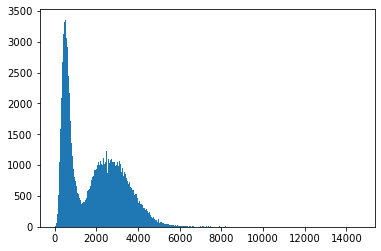

In [7]:
plt.hist(df.Prix_m2_total,bins=300);

# Plot heat map of the price on the target city : 

In [8]:
df['longitude_real'] = df.longitude.apply(degrees)
df['latitude_real'] = df.latitude.apply(degrees)

In [9]:
# Takes a lot of memory, increase nb_plots for more details
# Static map after that

center = [48.6339,2.44417]
nb_plots = 5e3

hmap = folium.Map(location= center, zoom_start=10)

max_price = float(df['Prix_m2_bati'].max())
min_price = float(df['Prix_m2_bati'].min())
colormap = cm.LinearColormap(colors=['blue','red'], vmin=min_price,vmax=max_price)



lat = list(df.loc[:nb_plots].latitude_real)
lon = list(df.loc[:nb_plots].longitude_real)
price = list(df.loc[:nb_plots].Prix_m2_bati)


for loc, p in tqdm(zip(zip(lat, lon), price)):
    folium.Circle(
        location=loc,
        radius=10,
        fill=True,
        color=colormap(p),
    ).add_to(hmap)
    
hmap.add_child(colormap)

display(hmap)

5001it [00:00, 28255.14it/s]


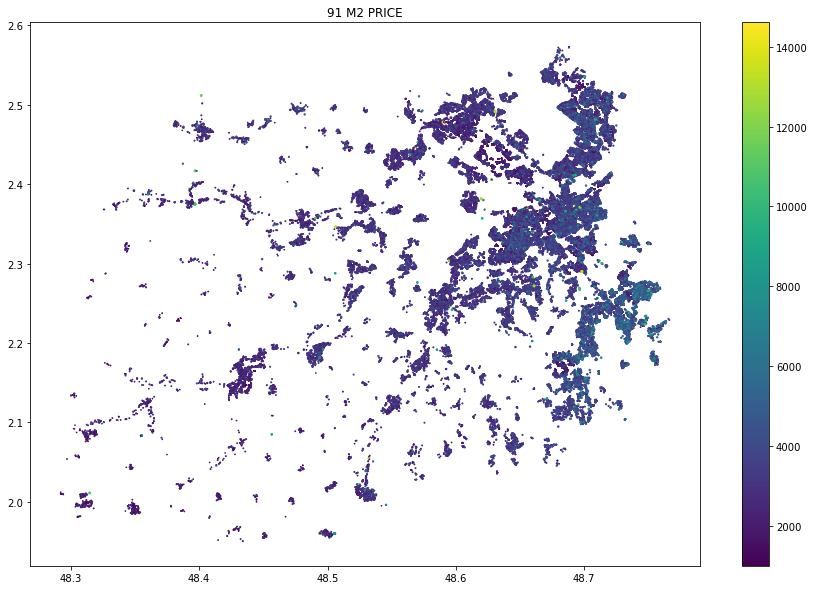

In [10]:
plt.figure(figsize = (15,10))
plt.scatter(df.latitude_real.values, df.longitude_real.values, c = df.Prix_m2_bati.values,s=5*df.Prix_m2_bati.values/df.Prix_m2_bati.values.max())
plt.colorbar()
plt.title('91 M2 PRICE')
plt.show()

In [11]:
def evaluate_model(y_test,y_pred):
    error= np.abs((y_test-y_pred)/y_test)*100
    print('Mean absolute percentage error = {}'.format(np.mean(error)))
    print('Median absolute percentage error = {}'.format(np.median(error)))

In [12]:
X_train, X_test, Y_train, Y_test = scsplit(df,df.Prix_m2_bati,test_size = 0.2,train_size = 0.8,stratify = df.valeur_fonciere,random_state=10)

In [13]:
index_train = X_train.index
index_test = X_test.index

prix_m2_train = Y_train.values
prix_m2_test = Y_test.values
vf_train = df.loc[index_train].valeur_fonciere
vf_test = df.loc[index_test].valeur_fonciere

In [14]:
categorical_features = ['nombre_pieces_principales','type_local','year']

quantitative_features = [
 'surface_reelle_bati',
 'surface_terrain',
 'nb_transac_quarter',
 'nb_transac_total',
 'Part des non ou peu diplômés dans la pop. non scolarisée de 15 ans ou + 2017',
 'Part des pers., dont le diplôme le plus élevé est le bepc ou le brevet, dans la pop. non scolarisée de 15 ans ou + 2017',
 'Part des pers., dont le diplôme le plus élevé est un CAP ou un BEP, dans la pop. non scolarisée de 15 ans ou + 2017',
 'Part des pers., dont le diplôme le plus élevé est le bac, dans la pop. non scolarisée de 15 ans ou + 2017',
 "Part des diplômés d'un BAC+3  ou BAC+4 dans la pop. non scolarisée de 15 ans ou + 2017",
 "Taux d'activité par tranche d'âge 2017",
 "Nb d'emplois au lieu de travail (LT) 2017",
 'Part des emplois sal. dans le nb d’emplois au LT 2017',
 'Part des cadres et prof. intellectuelles sup. dans le nb d’emplois au LT 2017',
 'Part des employés dans le nb d’emplois au LT 2017',
 "Taux d'activité par tranche d'âge 2017.1",
 "Taux d'activité par tranche d'âge 2017.2",
 'Résidences principales 2017',
 'dist_min_lycee',
 'dist_min_5_lycee',
 'dist_min_maternelle',
 'dist_min_ecoles_elementaires',
 'dist_min_colleges',
 'dist_min_5_colleges',
 'dist_min_sup',
 'dist_min_5_sup',
 'dist_min_supermarche',
 'dist_min_boulangerie',
 'dist_min_poste',
 'dist_min_pharmacie',
 'dist_min_aeroport',
 'dist_min_culture',
 'dist_min_generaliste',
 'dist_min_banque',
 'dist_min_urgence',
 'dist_min_specialiste',
 'dist_min_dent',
 'dist_min_infirimier',
 'dist_min_gare',
 'voisinage',
 'voisinage_total',
 'mean_dist_5_NN',
 'mean_dist_10_NN',
 'mean_dist_20_NN',
 'mean_dist_25_NN',
 'mean_dist_50_NN',
 'std_dist_5_NN',
 'std_dist_10_NN',
 'std_dist_20_NN',
 'std_dist_25_NN',
 'std_dist_50_NN',
 'Distance_plus_proche_ferré',
 'Distance_moyenne_5_plus_proches_ferrés',
 'Distance_moyenne_10_plus_proches_ferrés',
 'Noctilien_plus_proche',
 'Distance_plus_proche_bus',
 'Distance_moyenne_5_plus_proches_bus',
 'Distance_moyenne_10_plus_proches_bus',
 'std_distance_5_plus_proches_bus',
 'std_distance_10_plus_proches_bus']


X_train = X_train[categorical_features + quantitative_features]
X_test = X_test[categorical_features + quantitative_features]

In [15]:
preprocessor = ColumnTransformer(
        [
            ("preprocessor_cat",OneHotEncoder(handle_unknown = 'ignore'),categorical_features),
            ("preprocessor_quant",StandardScaler(),quantitative_features)
            
        ], remainder = 'drop')

In [16]:
MODEL = Pipeline(
        [
            ("preprocessor",preprocessor),
            ("regressor",LGBMRegressor(learning_rate=0.2,n_estimators=1000))
        ])


In [17]:
MODEL.fit(X_train,Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocessor_cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['nombre_pieces_principales',
                                                   'type_local',
                                                   'ligne_plus_proche_ferré',
                                                   'year']),
                                                 ('preprocessor_quant',
                                                  StandardScaler(),
                                                  ['surface_reelle_bati',
                                                   'surface_terrain',
                                                   'nb_transac_quarter',
                                                   'nb_transac_total',
                                                   'Part des non ou peu '
                     

In [18]:
predicted = MODEL.predict(X_test)
evaluate_model(Y_test,predicted)

Mean absolute percentage error = 14.134357118401052
Median absolute percentage error = 8.821562894082787


In [19]:
valeur_fonciere = vf_test
prediction_vf = predicted*X_test.surface_reelle_bati

In [20]:
evaluate_model(valeur_fonciere,prediction_vf)

Mean absolute percentage error = 14.134357118401045
Median absolute percentage error = 8.821562894082787


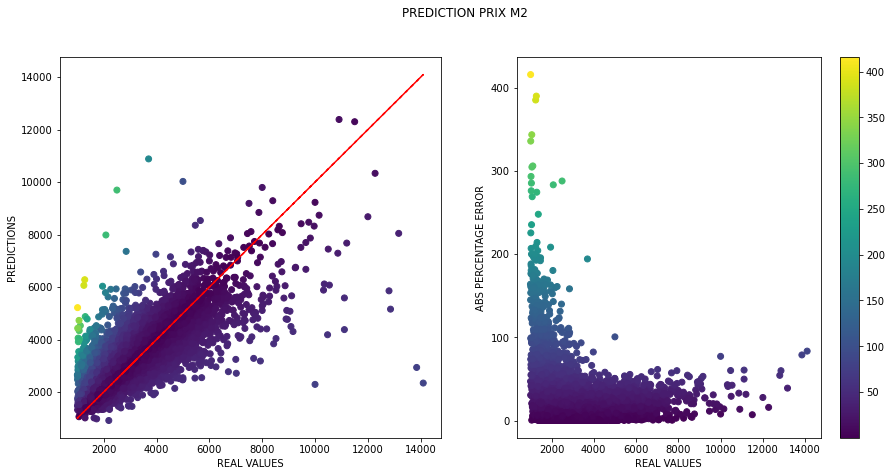

In [21]:
mape = np.abs((predicted - Y_test)/Y_test)*100

plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.scatter(Y_test,predicted,c= mape)
plt.plot(Y_test,Y_test,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(1,2,2)
mape = np.abs((predicted - Y_test)/Y_test)*100
plt.scatter(Y_test,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')
plt.suptitle('PREDICTION PRIX M2')
plt.colorbar()

Mean absolute percentage error = 14.134357118401045
Median absolute percentage error = 8.821562894082787


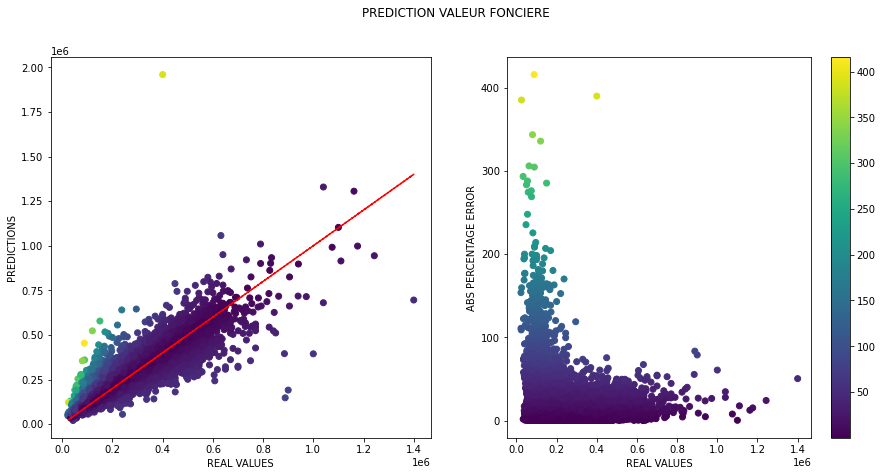

In [22]:
mape = np.abs((valeur_fonciere - prediction_vf)/valeur_fonciere)*100

evaluate_model(valeur_fonciere,prediction_vf)

plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.scatter(valeur_fonciere,prediction_vf,c= mape)
plt.plot(valeur_fonciere,valeur_fonciere,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(1,2,2)

plt.scatter(valeur_fonciere,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')
plt.suptitle('PREDICTION VALEUR FONCIERE')
plt.colorbar()

# Spatial distribution of the error : 

In [23]:
error = mape

hmap = folium.Map(location= center, zoom_start=10)

df_test = df[df.index.isin(index_test)] 
nb_plots = 1e3

max_error = max(error)
min_error = min(error)
mean_error = np.mean(error)
med_error = np.median(error)
colormap = cm.LinearColormap(colors=['lightblue','red'], index = [min_error,max_error],
                             vmin=min_error,vmax=max_error)



lat = list(df_test.reset_index().loc[:nb_plots].latitude_real)
lon = list(df_test.reset_index().loc[:nb_plots].longitude_real)
price = list(error)


for loc, p in tqdm(zip(zip(lat, lon), error)):
    folium.Circle(
        location=loc,
        radius=p,
        fill=True,
        color=colormap(p),
        fill_opacity=p/max_error).add_to(hmap)
    
hmap.add_child(colormap)

display(hmap)

1001it [00:00, 29441.87it/s]


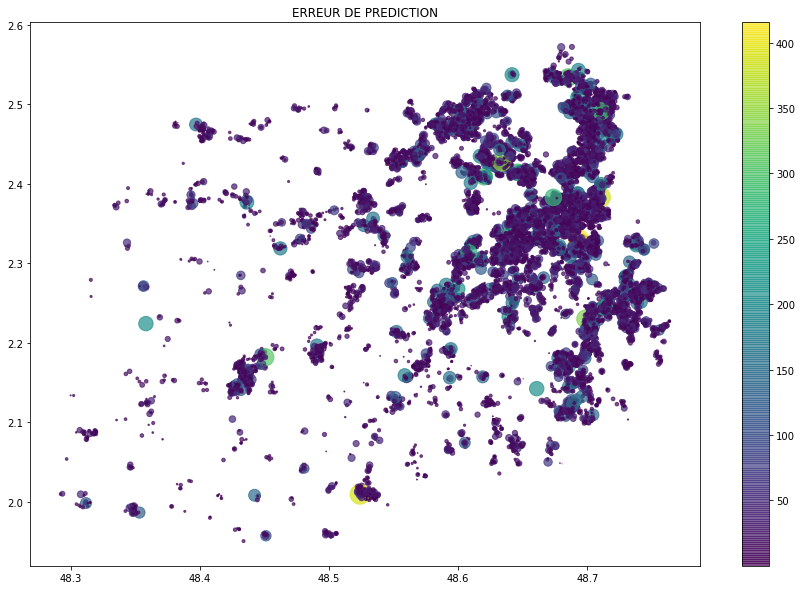

In [24]:
plt.figure(figsize = (15,10))
plt.scatter(df_test.latitude_real.values, df_test.longitude_real.values, c = error,s=error,alpha=0.7)
plt.colorbar()
plt.title('ERREUR DE PREDICTION')
plt.show()

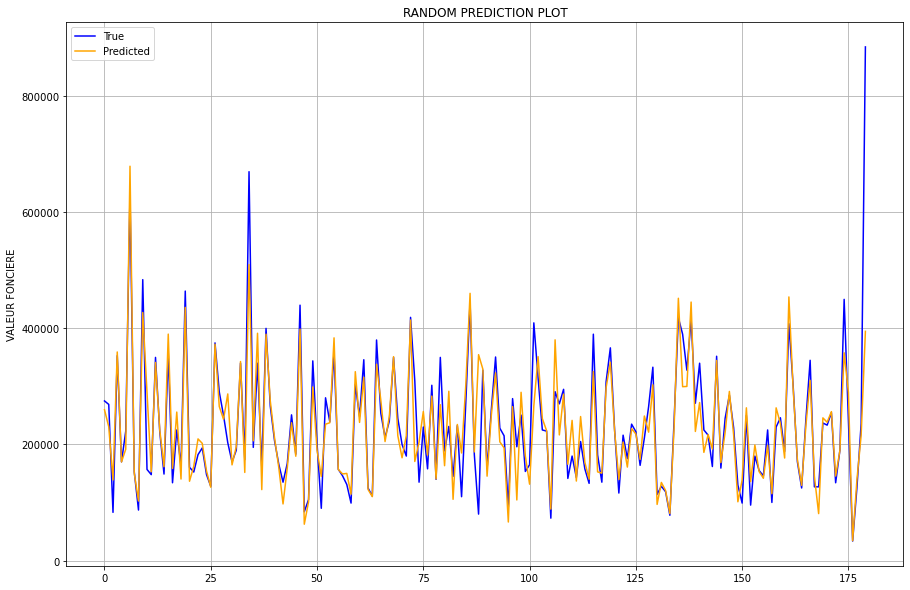

In [25]:
plt.figure(figsize=(15,10))
n = len(Y_test)
number = int(n/100)
array = np.arange(n)
shuffle(array)

i = randint(0,n-number)

prediction = prediction_vf
prediction_plot = []
true_plot = []

for indice in array[i:i+number]:
    true_plot.append(valeur_fonciere.values[indice])
    prediction_plot.append(prediction.values[indice])
    

plt.plot(range(number),true_plot,'b',label='True')
plt.plot(range(number),prediction_plot,'orange',label='Predicted')
plt.grid()
plt.title('RANDOM PREDICTION PLOT')
plt.ylabel('VALEUR FONCIERE')
plt.legend()

In [26]:
n_repeats = 5

feature_importances = permutation_importance(
    MODEL, X_test, Y_test, n_repeats=n_repeats
)

In [27]:
sorted_idx = feature_importances.importances_mean.argsort()[::-1]
names = X_test.columns.copy()

for i in range(len(names)):
    features = feature_importances.importances[sorted_idx].T[:,i]
    series = pd.Series(features)
    if i == 0 :
        dfa = pd.DataFrame(series,columns = ['Importance'])
        dfa['Features'] = np.array(names)[sorted_idx][i]
    else : 
        df2 = pd.DataFrame(series,columns = ['Importance'])
        df2['Features'] = np.array(names)[sorted_idx][i]
        dfa = pd.concat([dfa,df2])

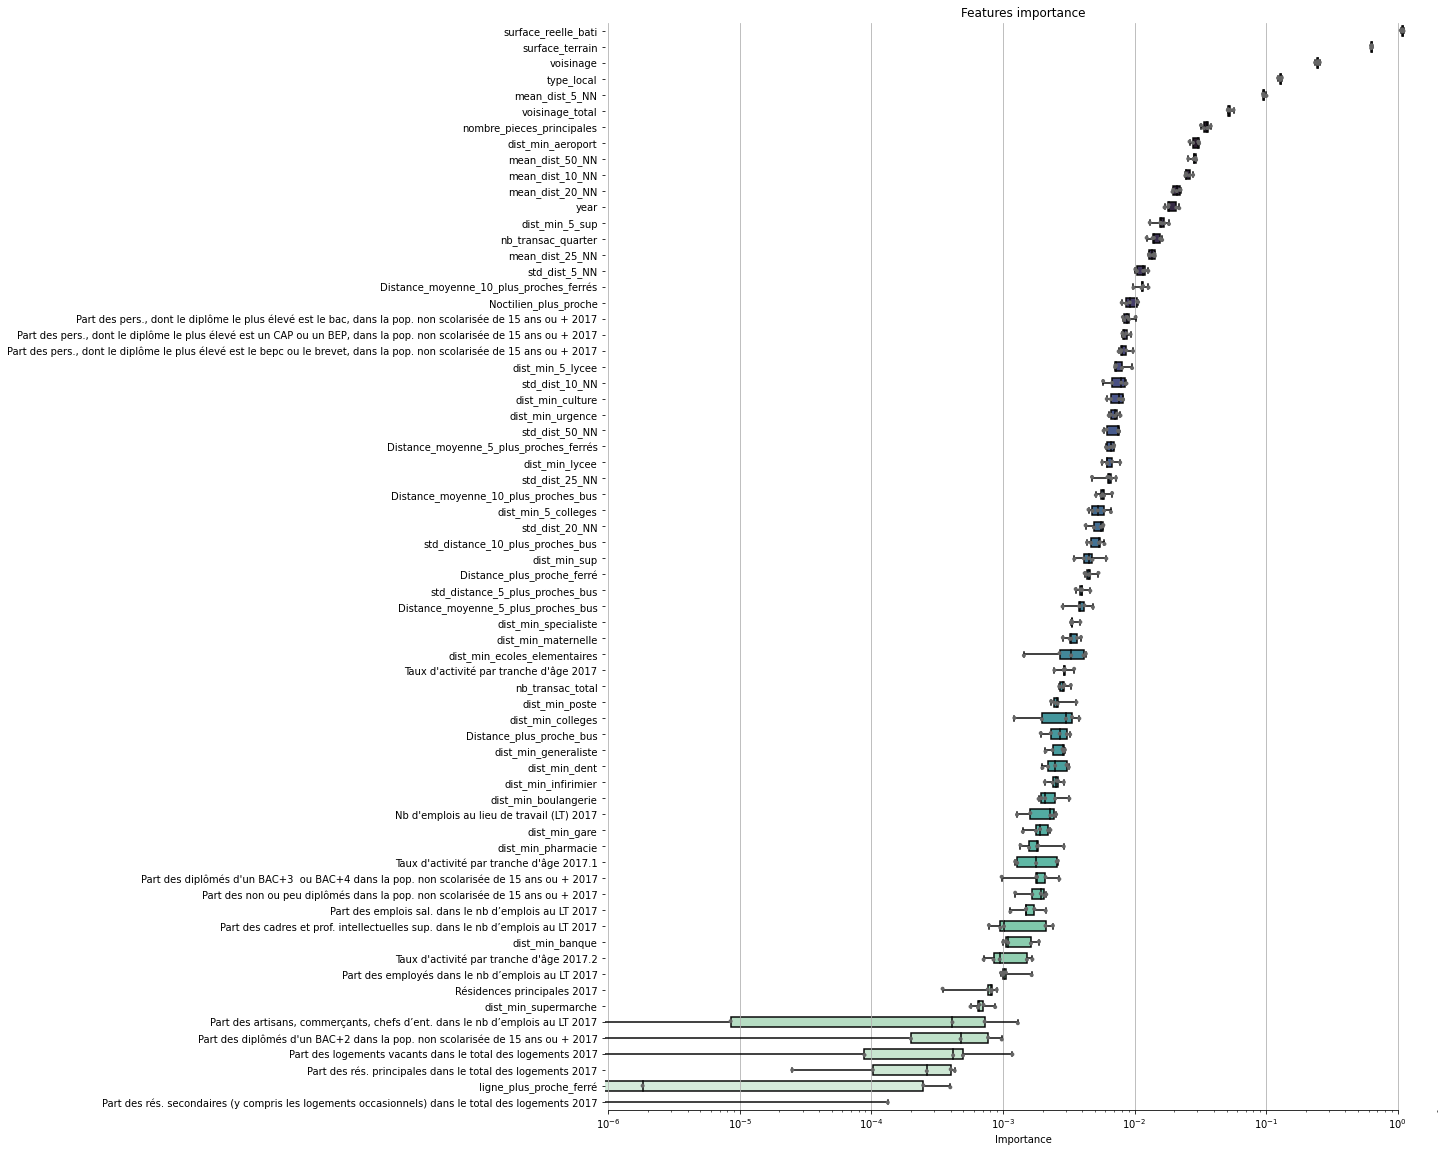

In [28]:
# Plot the orbital period with horizontal boxes

f, ax = plt.subplots(figsize=(15,20))
ax.set_xscale("log")
sns.boxplot(x='Importance', y='Features',data=dfa,
            whis=[0, 100], width=.6, palette="mako")


sns.stripplot(x='Importance', y='Features',data=dfa,
              size=4, color=".4", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
ax.set_title('Features importance');

# Neural Network

In [29]:
X_pre_train = X_train.copy()
X_pre_test = X_test.copy()
Y_train = prix_m2_train
Y_test = prix_m2_test

In [30]:
X_train_keras = preprocessor.transform(X_pre_train[categorical_features + quantitative_features])
X_test_keras = preprocessor.transform(X_pre_test[categorical_features + quantitative_features])

In [31]:
callback = EarlyStopping(patience=15,restore_best_weights = True)

In [32]:
# Decalaration of our neural network architechture. We use batchnormalization layers as well 
# as dropout to prevent overfitting
def create_network():
    model = Sequential()
    model.add(Dense(16, activation='relu',input_shape = (X_train_keras.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32, activation='selu'))
    model.add(Dense(16, activation='selu'))
    model.add(Dense(8, activation='selu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

    return model

In [33]:
keras_regressor = KerasRegressor(build_fn=create_network, epochs=1500,verbose=1,batch_size = 128)

In [34]:
keras_regressor.fit(X_train_keras,Y_train,callbacks=[callback],validation_split=0.2)

Train on 57628 samples, validate on 14408 samples
Epoch 1/1500
57628/57628 [==============================] - 1s 26us/step - loss: 1181.3620 - val_loss: 485.3293
Epoch 2/1500
57628/57628 [==============================] - 1s 22us/step - loss: 473.0242 - val_loss: 453.9742
Epoch 3/1500
57628/57628 [==============================] - 1s 22us/step - loss: 456.9971 - val_loss: 445.7731
Epoch 4/1500
57628/57628 [==============================] - 1s 22us/step - loss: 451.9986 - val_loss: 450.3676
Epoch 5/1500
57628/57628 [==============================] - 1s 23us/step - loss: 447.9518 - val_loss: 440.4806
Epoch 6/1500
57628/57628 [==============================] - 1s 25us/step - loss: 445.3063 - val_loss: 438.6411
Epoch 7/1500
57628/57628 [==============================] - 1s 24us/step - loss: 441.4702 - val_loss: 435.8456
Epoch 8/1500
57628/57628 [==============================] - 1s 22us/step - loss: 438.0420 - val_loss: 432.2483
Epoch 9/1500
57628/57628 [==============================] - 1

57628/57628 [==============================] - 1s 22us/step - loss: 406.8084 - val_loss: 411.8876
Epoch 74/1500
57628/57628 [==============================] - 1s 21us/step - loss: 405.9686 - val_loss: 412.2315
Epoch 75/1500
57628/57628 [==============================] - 1s 21us/step - loss: 406.2965 - val_loss: 411.3666
Epoch 76/1500
57628/57628 [==============================] - 1s 21us/step - loss: 405.6348 - val_loss: 412.9525
Epoch 77/1500
57628/57628 [==============================] - 1s 21us/step - loss: 405.9539 - val_loss: 412.4881
Epoch 78/1500
57628/57628 [==============================] - 1s 22us/step - loss: 406.0457 - val_loss: 411.3827
Epoch 79/1500
57628/57628 [==============================] - 1s 22us/step - loss: 406.0950 - val_loss: 413.8938
Epoch 80/1500
57628/57628 [==============================] - 1s 22us/step - loss: 406.5401 - val_loss: 437.6953
Epoch 81/1500
57628/57628 [==============================] - 1s 21us/step - loss: 406.3319 - val_loss: 413.8827
Epoch 

In [35]:
prediction = keras_regressor.predict(X_test_keras)
evaluate_model(prediction,Y_test)

18010/18010 [==============================] - 0s 8us/step
Mean absolute percentage error = 13.088311314942846
Median absolute percentage error = 9.148279711467454


In [36]:
prediction_vf = prediction*X_test.surface_reelle_bati
evaluate_model(prediction_vf,vf_test)

Mean absolute percentage error = 13.08831131494285
Median absolute percentage error = 9.148279711467453


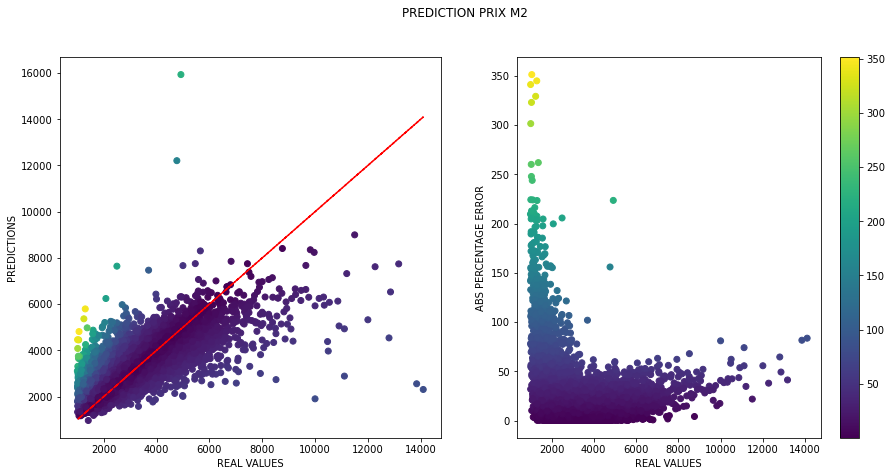

In [37]:
mape = np.abs((prediction - Y_test)/Y_test)*100

plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.scatter(Y_test,prediction,c= mape)
plt.plot(Y_test,Y_test,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(1,2,2)
mape = np.abs((prediction - Y_test)/Y_test)*100
plt.scatter(Y_test,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')
plt.suptitle('PREDICTION PRIX M2')
plt.colorbar()

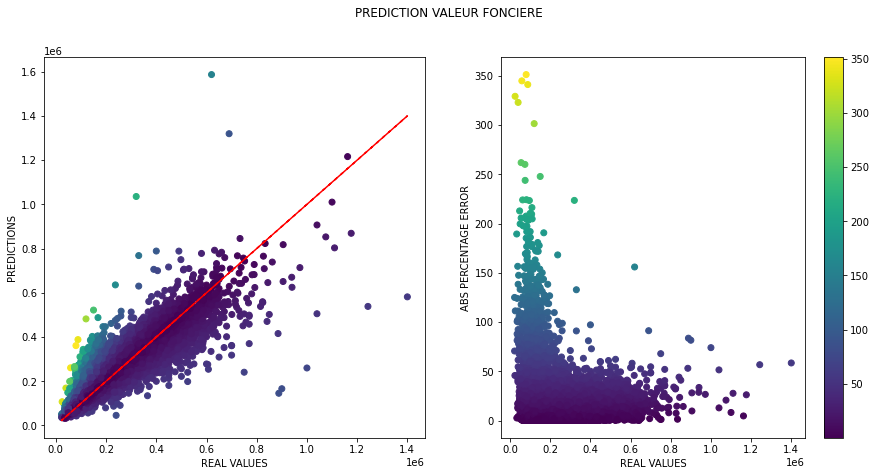

In [38]:
mape = np.abs((vf_test - prediction_vf)/vf_test)*100

plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.scatter(vf_test,prediction_vf,c= mape)
plt.plot(vf_test,vf_test,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(1,2,2)

plt.scatter(vf_test,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')
plt.suptitle('PREDICTION VALEUR FONCIERE')
plt.colorbar();

# MIXED MODEL 

In [39]:
mixed = np.average([prediction,predicted],axis=0,weights=[0.5,0.5])
evaluate_model(mixed,Y_test)

Mean absolute percentage error = 12.404508241421881
Median absolute percentage error = 8.605490657149204


In [40]:
part_keras = np.linspace(0,1,101)
list_mape = []
min_loss = np.inf 
best_tradeoff = 0
best_mixed = mixed

for i in part_keras : 
    mixed = np.average([prediction,predicted],axis=0,weights=[i,1-i])
    mae = np.mean(np.abs(mixed-Y_test))
    list_mape.append(mae)
    if mae < min_loss : 
        best_tradeoff = i 
        min_loss = mae
        best_mixed = mixed
        

Text(0.5, 1.0, 'BEST PART KERAS : 0.4')

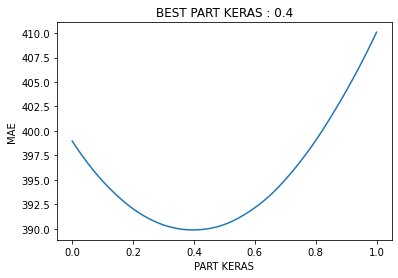

In [41]:
plt.figure()
plt.plot(part_keras,list_mape)
plt.ylabel('MAE')
plt.xlabel('PART KERAS')
plt.title('BEST PART KERAS : {}'.format(best_tradeoff))

In [42]:
evaluate_model(best_mixed,Y_test)

Mean absolute percentage error = 12.383760060155877
Median absolute percentage error = 8.55525057005049


In [43]:
Boundary = 20

ap_error = (np.abs(best_mixed - Y_test)/Y_test)*100
print("Prediction with less than {}% error represents {}% of predictions.".format(Boundary,(1 - (len(Y_test) - sum(ap_error < Boundary))/len(Y_test))*100))

Prediction with less than 20% error represents 81.63242642976124% of predictions.


# Make the true training of the two models, save optimal tradeoff

In [44]:
X = df[categorical_features + quantitative_features]
Y = df.Prix_m2_bati

In [45]:
preprocessor = ColumnTransformer(
        [
            ("preprocessor_cat",OneHotEncoder(handle_unknown = 'ignore'),categorical_features),
            ("preprocessor_quant",StandardScaler(),quantitative_features)
            
        ], remainder = 'drop')

In [46]:
MODEL = Pipeline(
        [
            ("preprocessor",preprocessor),
            ("regressor",LGBMRegressor(learning_rate=0.2,n_estimators=1000))
        ])

In [47]:
MODEL.fit(X,Y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocessor_cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['nombre_pieces_principales',
                                                   'type_local',
                                                   'ligne_plus_proche_ferré',
                                                   'year']),
                                                 ('preprocessor_quant',
                                                  StandardScaler(),
                                                  ['surface_reelle_bati',
                                                   'surface_terrain',
                                                   'nb_transac_quarter',
                                                   'nb_transac_total',
                                                   'Part des non ou peu '
                     

In [48]:
X_keras = preprocessor.transform(X)

In [49]:
callback = EarlyStopping(patience=15,restore_best_weights = True)

In [50]:
# Decalaration of our neural network architechture. We use batchnormalization layers as well 
# as dropout to prevent overfitting
def create_network():
    model = Sequential()
    model.add(Dense(16, activation='relu',input_shape = (X_keras.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32, activation='selu'))
    model.add(Dense(16, activation='selu'))
    model.add(Dense(8, activation='selu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

    return model

In [51]:
keras_regressor = KerasRegressor(build_fn=create_network, epochs=1500,verbose=1,batch_size = 128)

In [52]:
keras_regressor.fit(X_keras,Y,callbacks=[callback],validation_split=0.2)

Train on 72036 samples, validate on 18010 samples
Epoch 1/1500
72036/72036 [==============================] - 2s 24us/step - loss: 996.0042 - val_loss: 592.1706
Epoch 2/1500
72036/72036 [==============================] - 1s 20us/step - loss: 452.6857 - val_loss: 573.1873
Epoch 3/1500
72036/72036 [==============================] - 1s 20us/step - loss: 445.2787 - val_loss: 589.8414
Epoch 4/1500
72036/72036 [==============================] - 2s 22us/step - loss: 440.8323 - val_loss: 577.0067
Epoch 5/1500
72036/72036 [==============================] - 1s 20us/step - loss: 435.4152 - val_loss: 568.5206
Epoch 6/1500
72036/72036 [==============================] - 1s 19us/step - loss: 430.5144 - val_loss: 572.4777
Epoch 7/1500
72036/72036 [==============================] - 1s 19us/step - loss: 426.9543 - val_loss: 591.0290
Epoch 8/1500
72036/72036 [==============================] - 1s 19us/step - loss: 424.1600 - val_loss: 566.6266
Epoch 9/1500
72036/72036 [==============================] - 1s

72036/72036 [==============================] - 1s 18us/step - loss: 403.0845 - val_loss: 535.9125
Epoch 74/1500
72036/72036 [==============================] - 1s 18us/step - loss: 402.5832 - val_loss: 516.5846
Epoch 75/1500
72036/72036 [==============================] - 1s 18us/step - loss: 402.8682 - val_loss: 517.2173
Epoch 76/1500
72036/72036 [==============================] - 1s 18us/step - loss: 403.1289 - val_loss: 518.9838
Epoch 77/1500
72036/72036 [==============================] - 1s 18us/step - loss: 402.4201 - val_loss: 514.7351
Epoch 78/1500
72036/72036 [==============================] - 1s 18us/step - loss: 402.5788 - val_loss: 512.6284
Epoch 79/1500
72036/72036 [==============================] - 1s 19us/step - loss: 402.4337 - val_loss: 526.9181
Epoch 80/1500
72036/72036 [==============================] - 2s 21us/step - loss: 402.3521 - val_loss: 529.9471
Epoch 81/1500
72036/72036 [==============================] - 2s 22us/step - loss: 402.4650 - val_loss: 524.9398
Epoch 

# Saving models

In [53]:
filename = './models/Pipeline_LGBM_{}.sav'.format(DEPARTMENT)
pickle.dump(MODEL, open(filename, 'wb'))

In [54]:
filename = './models/preprocessor_keras_{}.sav'.format(DEPARTMENT)
pickle.dump(preprocessor, open(filename, 'wb'))

In [55]:
filename = './models/keras_{}.h5'.format(DEPARTMENT)
keras_regressor.model.save(filename)